In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

/Users/cztomsik/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 695.88it/s]


In [2]:
device = "cpu"
block_size = 100

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long).to(device)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - 500))
test = data.Subset(dataset, range(len(dataset) - 500, len(dataset)))

In [3]:
# inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
class MinGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, dropout):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Dropout(dropout),
            nn.Sequential(*[DecoderLayer(embed_dim, dropout) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens, top_k=10):
        for _ in range(max_new_tokens):
            out = self(input_ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            input_ids = torch.cat((input_ids, step_res), dim=1)

        return input_ids

class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTFlat(embed_dim, dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).to(device))

    def forward(self, x):
        B, T, _ = x.shape
        x = self.ln1(x)
        x = x + self.attn(x, self.mask[:T, :T])
        x = x + self.mlp(self.ln2(x))
        return x

# inspired by https://arxiv.org/pdf/2105.14103.pdf and https://github.com/BlinkDL/RWKV-LM
# but RWKV is way more advanced (and better)
#
# when compared to AFT paper:
# - the main idea is still just weighted average
# - looking at attention weights it's mostly diagonal, so a lot of waste
# - so let's make `w` a flat vector, and don't exponentiate it for the numerator part
# - divide by a cumulative sum of exp(k)
class AFTFlat(nn.Module):
    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        # init with decay as this is what network learns anyway
        self.w = nn.Parameter((1 + torch.arange(block_size, dtype=torch.float)).softmax(dim=0), requires_grad=True)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        exp_k = k.clamp(max=20).exp()
        wkv = torch.einsum("tk,bkc->btc", circulant.apply(self.w)[:T, :T] * mask, exp_k * v)
        Yt = F.sigmoid(q) * wkv / torch.cumsum(exp_k, dim=1)
        return self.drop(self.proj(Yt))

# less obvious than expected but it's not enough to compute the circulant matrix from the 1D input,
# we also need to somehow make the gradient flow back
class circulant(torch.autograd.Function):
    @staticmethod
    def forward(ctx, t):
        ctx.save_for_backward(t)
        return torch.cat([t, t[:-1]]).unfold(0, block_size, 1).flip(0)

    @staticmethod
    def backward(ctx, grad_out):
        t, = ctx.saved_tensors
        # not sure if this is correct but the plots look ok
        return t * grad_out[-1]

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.004):
        super().__init__()
        self.lr = lr
        self.model = MinGPT(vocab_size, embed_dim=128, num_layers=3, dropout=0.1)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=100, num_workers=0, sampler=data.RandomSampler(train, False, 5_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=16, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            x = torch.tensor([dataset.stoi[s] for s in "And now "], dtype=torch.long)[None,...].to(device)
            y = self.model.generate(x, 64)[0]
            print("".join([dataset.itos[int(i)] for i in y]))

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

model = Model(len(dataset.vocab))
trainer = pl.Trainer(gradient_clip_val=1.0, max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else "cpu")
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | MinGPT | 610 K 
---------------------------------
610 K     Trainable params
0         Non-trainable params
610 K     Total params
2.442     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 31.73it/s]

/Users/cztomsik/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cztomsik/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 35.96it/s]And now A $ $WVyndzqumDSSXs,,t.PaDXrR! AMLzC,qn?YG$ze,SKqiZCR:eCktusfFpJ
                                                                           

/Users/cztomsik/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 82/82 [00:12<00:00,  6.55it/s, loss=2.34, v_num=254]And now and, be a by maret sod,
Bupien whe the ais the the med ange of b
Epoch 1: 100%|██████████| 82/82 [00:12<00:00,  6.37it/s, loss=2.08, v_num=254, test_loss=2.220]And now macon,
That wor saist then all a sit shad in our have helove mou
Epoch 4: 100%|██████████| 82/82 [00:13<00:00,  6.18it/s, loss=1.84, v_num=254, test_loss=1.920]And now thy seem's
And this the reath, a me, wombl to way,
The be mocke 
Epoch 5: 100%|██████████| 82/82 [00:13<00:00,  6.01it/s, loss=1.79, v_num=254, test_loss=1.870]And now idest specutionst and truuness have tear that,
Heard is spacien 
Epoch 6: 100%|██████████| 82/82 [00:12<00:00,  6.39it/s, loss=1.76, v_num=254, test_loss=1.820]And now so my lord.

MARCIUS:
Ayrice not sees.

Set he severy such alls 
Epoch 7: 100%|██████████| 82/82 [00:12<00:00,  6.49it/s, loss=1.73, v_num=254, test_loss=1.720]And now mast me this hand of all,
Or they strow, mast at ones dreath?
Th
Epoch 8: 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 82/82 [00:13<00:00,  6.24it/s, loss=1.52, v_num=254, test_loss=1.500]


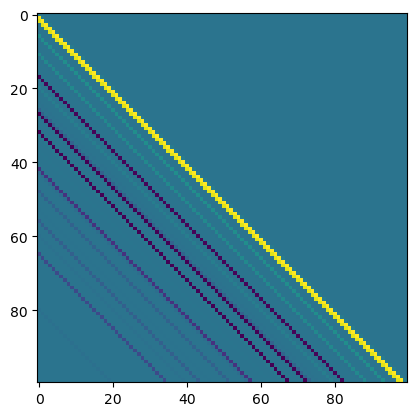

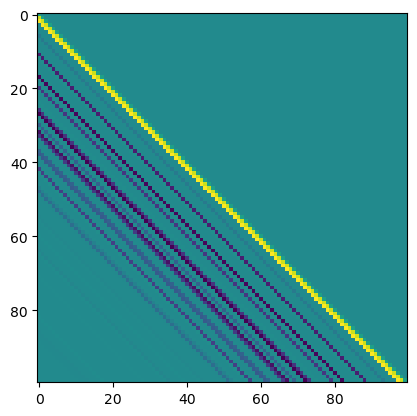

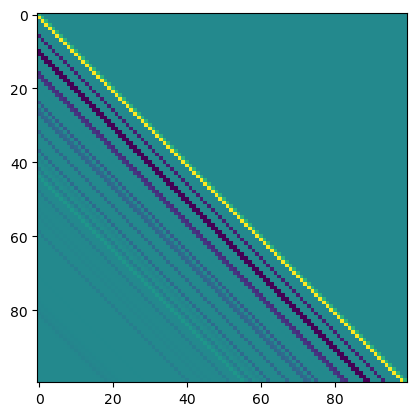

In [5]:
from matplotlib import pyplot as plt
for b in model.model.transformer[2]:
    w = circulant.apply(b.attn.w).detach() * torch.tril(torch.ones(block_size, block_size))
    plt.figure()
    plt.imshow(w.detach())

In [ ]:
y = model.to(device).model.generate(torch.tensor([dataset.stoi[s] for s in "O God, O God!"]).unsqueeze(0).to(device), 650)
print("".join([dataset.itos[int(i)] for i in y[0]]))

O God, O God!
And supl my freeself, and it; and, and
Bembataber.

POLIZA:
What you has; but say are am well shall hear that fumest in this patroan.

Mosst fear mother's of at thee. What sarewas!
Morabe too braise and in suntleman away.
Doth teep on my from intlitte, by miness met wentemeny to dispail you man; them as hat mand
Be thenry of our hose, be thou and man
To lift, so manery so must all of my are soul speak. Why, but
Onure have it hean to my lost olds
Withis, a was were him seems,
And will the wining or ous all your front me
Thou and wild make armining. I womediall humb bearn.

BRUTUS:
O three he suil, he droar this affusionis to.
Which yoult tan,
